In [1]:
# Helper to adjust contrast of avg seg of a given structure

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/Others
Fri Jun 24 11:02:27 PDT 2022


In [3]:
import os
import sys
import pickle
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control_main = controller.Controller(config)

In [5]:
# Controller form cvapipe_analysis
path_step = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance/shapemode")
control, device = common.get_managers_from_step_path(path_step)
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


### Create domain

In [6]:
gene = "PXN"

In [7]:
importlib.reload(io)

<module 'cvapipe_analysis.tools.io' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/cvapipe_analysis/tools/io.py'>

In [8]:
morphs = []
for staging, ds in zip(["local_staging_variance_m1m2", "local_staging_variance_m3", "local_staging_m1m2", "local_staging_m3"], ["m1", "m2", "m1", "m2"]):
    path_step = Path(f"/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/{staging}/shapemode")
    control, device = common.get_managers_from_step_path(path_step)

    nisos = control.get_number_of_interpolating_points()
    inner_alias = control.get_inner_most_alias_to_parameterize()
    outer_alias = control.get_outer_most_alias_to_parameterize()
    inner_mesh = device.read_vtk_polydata(f"../MovieMitosis/avgshape/{ds}_{inner_alias}_matched.vtk")
    outer_mesh = device.read_vtk_polydata(f"../MovieMitosis/avgshape/{ds}_{outer_alias}_matched.vtk")
    domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
    coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
        seg_mem=(domain>0).astype(np.uint8),
        seg_nuc=(domain>1).astype(np.uint8),
        lmax=control.get_lmax(), nisos=[nisos, nisos]
    )
    coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
    coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

    row = pd.Series({"shape_mode": "NUC_MEM_PC1", "mpId": 1, "aggtype": "avg", "alias": "STR", "structure": gene})
    rep = device.read_agg_parameterized_intensity(row, normalized=False)
    morphed = cytoparam.morph_representation_on_shape(
        img=domain,
        param_img_coords=coords_param,
        representation=rep
    )
    morphs.append(morphed)

In [9]:
vmin, vmax = np.array([np.percentile(m[m>0], [0, 99]) for m in morphs[:2]]).mean(axis=0)

In [10]:
# vmin, vmax = control_main.get_optimal_avgseg_contrast(gene)
# print(vmin, vmax)

In [15]:
vmin, vmax = 0, 11

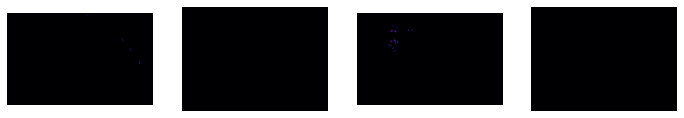

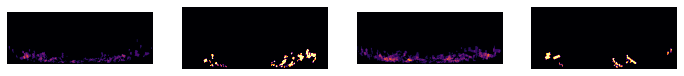

In [16]:
cm = [int(u.mean()) for u in np.where(domain>1)]
fig, axs = plt.subplots(1,len(morphs), figsize=(3*len(morphs),3))
for morph, ax in zip(morphs, axs):
    ax.axis("off")
    ax.imshow(morph[cm[0]], cmap="inferno", vmin=vmin, vmax=vmax, origin="lower")
plt.show()
cm = [int(u.mean()) for u in np.where(domain>1)]
fig, axs = plt.subplots(1,len(morphs), figsize=(3*len(morphs),3))
for morph, ax in zip(morphs, axs):
    ax.axis("off")
    ax.imshow(morph[:,cm[1]], cmap="inferno", vmin=vmin, vmax=vmax, origin="lower")
plt.show()